In [1]:
import numpy as np
import pandas as pd
import causalnex
import sdeint
import networkx as nx

from functools import partial

In [2]:
# check adjacency matrix notation E = i -> j, i = col, j = row
# causalnex uses networkx
edge_list = [
    (1, 0),
]
print(edge_list)
G = nx.DiGraph(edge_list)
adj_matrix = nx.adjacency_matrix(G)
print(adj_matrix.todense())

[(1, 0)]
[[0 1]
 [0 0]]


In [3]:
def linear(x, t, A):
    return A @ x

def simulate_toy_linear(
    p, T, A, sigma=0.1, delta_t=0.1, burn_in=0, seed=None
):
    if seed is not None:
        np.random.seed(seed)

    def GG(x, t):
        p = len(x)
        return np.diag([sigma] * p)

    x0 = np.random.normal(scale=1, size=p)
    t = np.linspace(0, (T + burn_in) * delta_t, T + burn_in)
    lin = partial(linear, A=A)
    # X = odeint(lin, x0, t)
    X = sdeint.itoint(lin, GG, x0, t)

    GC = (np.abs(A) > 0).astype(np.int64)
    return X[burn_in:], GC


In [4]:
A_dag = [
     [0, 0.5, 0],
     [0, 0, 0],
     [0, 0.25, 0]
     ]
A_dag = np.array(A_dag)
print('DAG:')
print(A_dag)

# Cyclic graph example
A = [
     [0, 0.5, 0],
     [0.5, 0, 0.25],
     [0, 0.25, 0]
     ]
A = np.array(A)
print('\nCyclic Graph')
print(A)

DAG:
[[0.   0.5  0.  ]
 [0.   0.   0.  ]
 [0.   0.25 0.  ]]

Cyclic Graph
[[0.   0.5  0.  ]
 [0.5  0.   0.25]
 [0.   0.25 0.  ]]


In [5]:
# simulate DAG system
trajectories = [simulate_toy_linear(p=A_dag.shape[0], T=2, A=A_dag, seed=1) for i in range(500)]

X_dag, GC_dag = zip(*trajectories)
X_dag = np.array(X_dag)
GC_dag = np.array(GC_dag)

print(X_dag.shape, GC_dag.shape)
print(X_dag[0])
print(GC_dag[0])

# simulate cyclic system
trajectories = [simulate_toy_linear(p=A.shape[0], T=2, A=A, seed=1) for i in range(500)]

X, GC = zip(*trajectories)
X = np.array(X)
GC = np.array(GC)

print(X.shape, GC.shape)
print(X[0])
print(GC[0])

(500, 2, 3) (500, 3, 3)
[[ 1.62434536 -0.61175641 -0.52817175]
 [ 1.51518511 -0.57305421 -0.66168751]]
[[0 1 0]
 [0 0 0]
 [0 1 0]]
(500, 2, 3) (500, 3, 3)
[[ 1.62434536 -0.61175641 -0.52817175]
 [ 1.5219864  -0.44085174 -0.65828686]]
[[0 1 0]
 [1 0 1]
 [0 1 0]]


In [6]:
from causalnex.structure.notears import from_numpy
from causalnex.structure import StructureModel
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

import warnings
warnings.filterwarnings("ignore")  # silence warnings

In [7]:
# Predict DAG
d = X_dag[:, 1, :].shape[-1]
sm_dag = from_numpy(X_dag[:, 1, :], w_threshold=1e-3)
dag_pred_dict = sm_dag.adj

print('Egdes pred:', sm_dag.edges)
G_dag_pred = nx.adjacency_matrix(nx.DiGraph(sm_dag.edges))

A_dag_pred = np.zeros((d, d))
for node, adj in dag_pred_dict.items():
    if adj:
        for e in adj:
            A_dag_pred[e, node] = adj[e]['weight'] # following networx adj orientation

print('\nPredicted DAG: \n')
print(G_dag_pred.todense())
print(A_dag_pred)

Egdes pred: [(1, 0), (1, 2), (2, 0)]

Predicted DAG: 

[[0 1 1]
 [0 0 0]
 [0 1 0]]
[[ 0.         -0.84713451 -1.55607187]
 [ 0.          0.          0.        ]
 [ 0.          1.15257811  0.        ]]


In [8]:
# Predict Cyclic directed graph
d = X[:, 1, :].shape[-1]
sm_cyc = from_numpy(X[:, 1, :], w_threshold=1e-3)
cyc_pred_dict = sm_cyc.adj

print('Egdes pred:', sm_cyc.edges)
G_cyc_pred = nx.adjacency_matrix(nx.DiGraph(sm_cyc.edges))

A_cyc_pred = np.zeros((d, d))
for node, adj in cyc_pred_dict.items():
    if adj:
        for e in adj:
            A_cyc_pred[e, node] = adj[e]['weight'] # following networx adj orientation

print('\nPredicted Cyclic Graph: \n')
print(G_cyc_pred.todense())
print(A_cyc_pred)


Egdes pred: [(1, 0), (1, 2), (2, 0)]

Predicted Cyclic Graph: 

[[0 1 1]
 [0 0 0]
 [0 1 0]]
[[ 0.         -1.0997659  -1.57417817]
 [ 0.          0.          0.        ]
 [ 0.          1.48833398  0.        ]]


In [9]:
# import l-DynGFN learned DAG
path = '/home/mila/l/lazar.atanackovic/dyn-gfn/examples/dyn_gfn_A_est/A_dag_1024_mean.csv'
df_dyngfn_dag = pd.read_csv(path, delimiter=',', header=None)
print(df_dyngfn_dag.values)
A_dyngfn_dag = df_dyngfn_dag.to_numpy()

# import l-DynGFN learned Cyclic Graph
path = '/home/mila/l/lazar.atanackovic/dyn-gfn/examples/dyn_gfn_A_est/A_cyc_1024_mean.csv'
df_dyngfn_cyc = pd.read_csv(path, delimiter=',', header=None)
print(df_dyngfn_cyc.values)
A_dyngfn_cyc = df_dyngfn_cyc.to_numpy()

[[ 0.         -0.04081305  0.        ]
 [ 0.          0.03726917  0.        ]
 [-0.03696612  0.          0.00184038]]
[[0.         0.54210287 0.        ]
 [0.56031996 0.         0.17923339]
 [0.         0.21360396 0.        ]]


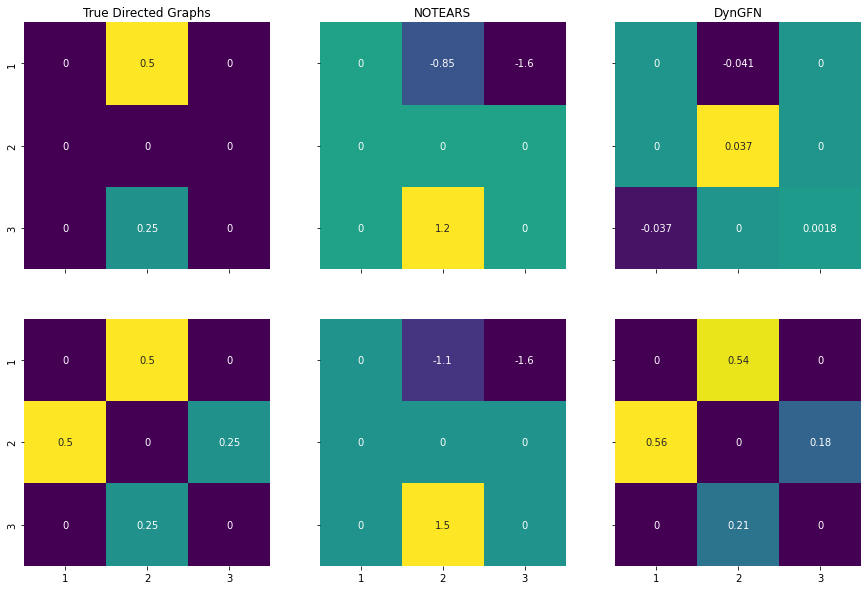

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(2, 3, figsize=(15,10), sharex=True, sharey=True)

ticks = ["1", "2", "3"]
sns.heatmap(A_dag, annot=A_dag, ax=axs[0, 0], cbar=False, cmap="viridis")
sns.heatmap(A_dag_pred, annot=A_dag_pred, ax=axs[0, 1], cbar=False, cmap="viridis")
sns.heatmap(A_dyngfn_dag, annot=A_dyngfn_dag, ax=axs[0, 2], cbar=False, cmap="viridis")
sns.heatmap(A, annot=A, ax=axs[1, 0], cbar=False, cmap="viridis")
sns.heatmap(A_cyc_pred, annot=A_cyc_pred, ax=axs[1, 1], cbar=False, cmap="viridis")
sns.heatmap(A_dyngfn_cyc, annot=A_dyngfn_cyc, ax=axs[1, 2], cbar=False, cmap="viridis")

axs[0, 0].set_yticklabels(ticks)
axs[0, 0].set_xticklabels(ticks)

#axs[0, 0].set_ylabel('Acyclic')
#axs[1, 0].set_ylabel('Cyclic')
axs[0, 0].title.set_text('True Directed Graphs')
axs[0, 1].title.set_text('NOTEARS')
axs[0, 2].title.set_text('DynGFN')

plt.show()
fig.savefig('/home/mila/l/lazar.atanackovic/dyn-gfn/examples/figures/toy_example.pdf')


In [19]:
from sklearn.metrics import roc_auc_score

# calculate AUCROC DAG
#print(X_dag[0])
#print((A_dag_pred != 0).astype(int))
AUC_dag_notears = roc_auc_score(GC_dag[0].flatten(), A_dag_pred.flatten())
AUC_dag_dyngfn = roc_auc_score(GC_dag[0].flatten(), A_dyngfn_dag.flatten())
print('DAG')
print('NOTEARS:', AUC_dag_notears)
print('DynGFN:', AUC_dag_dyngfn)
print('----------------')

# calculate AUCROC DAG
AUC_cyc_notears = roc_auc_score(GC[0], A_cyc_pred)
AUC_cyc_dyngfn = roc_auc_score(GC[0], A_dyngfn_cyc)
print('Cyclic')
print('NOTEARS:', AUC_cyc_notears)
print('DynGFN:', AUC_cyc_dyngfn)

DAG
NOTEARS: 0.5714285714285714
DynGFN: 0.2142857142857143
----------------
Cyclic
NOTEARS: 0.5833333333333334
DynGFN: 1.0


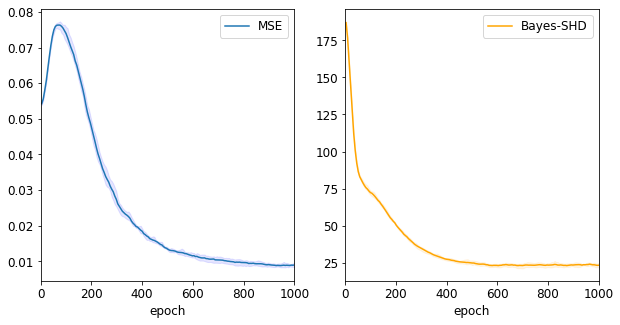

In [ ]:
path = '/home/mila/l/lazar.atanackovic/dyn-gfn/examples/loss_plots/wandb_export_2023-08-07T15_19_57.170-04_00_MSE.csv'
df_mse = pd.read_csv(path, delimiter=',')

path = '/home/mila/l/lazar.atanackovic/dyn-gfn/examples/loss_plots/wandb_export_2023-08-07T15_20_08.065-04_00_BAYES_SHD.csv'
df_shd = pd.read_csv(path, delimiter=',')


plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(1, 2, figsize=(10,5))

y = df_mse['model/_target_: src.models.parallel_energy_gfn_module.PerNodeParallelLinearTrainableCausalGraphGFlowNetModule - val/mse']
axs[0].plot(
    df_mse['Step'], 
    y,
    )
axs[0].fill_between(
    df_mse['Step'], 
    df_mse['model/_target_: src.models.parallel_energy_gfn_module.PerNodeParallelLinearTrainableCausalGraphGFlowNetModule - val/mse__MAX'],
    df_mse['model/_target_: src.models.parallel_energy_gfn_module.PerNodeParallelLinearTrainableCausalGraphGFlowNetModule - val/mse__MIN'],
    color='b', 
    alpha=.1,
    )
axs[0].set_xlim([0, 1000])
axs[0].legend(['MSE'])
axs[0].set_xlabel('epoch')

y = df_shd['model/_target_: src.models.parallel_energy_gfn_module.PerNodeParallelLinearTrainableCausalGraphGFlowNetModule - val/bayes_shd']
axs[1].plot(
    df_shd['Step'], 
    y,
    color='orange',
    )
axs[1].fill_between(
    df_shd['Step'], 
    df_shd['model/_target_: src.models.parallel_energy_gfn_module.PerNodeParallelLinearTrainableCausalGraphGFlowNetModule - val/bayes_shd__MAX'],
    df_shd['model/_target_: src.models.parallel_energy_gfn_module.PerNodeParallelLinearTrainableCausalGraphGFlowNetModule - val/bayes_shd__MIN'],
    color='orange', 
    alpha=.1,
    )
axs[1].set_xlim([0, 1000])
axs[1].legend(['Bayes-SHD'])
axs[1].set_xlabel('epoch')

plt.show()
fig.savefig('/home/mila/l/lazar.atanackovic/dyn-gfn/examples/figures/training_val_curves.pdf')